In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.multicomp import MultiComparison

from scipy import stats
import scipy 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

### 자료 소개

**`grid_250_all.csv`는 전주시를 250x250 나눈 후 인구와 공간적 데이터, 그리고 범죄주의구간(폭행, 절도, 성폭행) 등급의 강도로 구성되어있다.  
해당 데이터를 통해 전주시의 3대 범죄 발생에 영향을 끼치는 요인을 파악 후 범죄 위험지역에 대해 판단해 보려한다.** 

**데이터는 국가정보포털에서 격자별 인구 및 건축물에 대한 데이터를 수집하였으며, 가로등 주차장 등은 각 데이터의 좌표를 기준으로 격자내의 개수를 입력하였다.**  
**범죄주의구간은 생활안전지도의 치안사고발생현황을 바탕으로 만들어진 범죄주의구간 (1~10등급)의 지도를 이용하여 격자별 주의구간의 등급을 산정했다. (각 등급의 최대값)**  
자료는 총 43개의 변수로 구성되어 있으며, 격자는 총 918개이다. 

#### raw data
<code>gird_250</code> = 전주시 범죄관련 데이터
- <code>INDEX</code> = 인덱스
- <code>ID</code> = 각 격자의 고유 ID
- <code>총인구</code> = 격자별 총인구
- <code>고등여성인구</code> = 격자별 고등학생 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>20대여성인구</code> = 격자별 20대 여성인구(이 변수는 성폭력 취약인구에 포함)
- <code>유소년인구</code> = 격자별 유소년인구(0~14세)
- <code>고령인구</code> = 격자별 고령인구(65세 이상)
- <code>30년이상35년미만건축물</code> = 30년이상 35년미만건축물의 수 
- <code>35년이상건축물</code> = 35년이상 건축물 
- <code>개별주택가격</code> = 격자별 개별주택가격의 평균 
- <code>공시지가</code> = 격자별 평균 공시지가 
- <code>행정동코드</code> = 격자가 속한 행정동
- <code>가로등</code> = 격자별 가로등의 수 
- <code>공영주차장</code> = 격자별 공영주차장수
- <code>공중화장실</code> = 격자별 공중화장실수
- <code>교육시설</code> = 격자별 교육시설의 수 (학원, 어린이집)
- <code>대규모점포</code> = 격자별 대규모 점포의 수 (홈플러스, 이마트 등)
- <code>대부업현황</code> = 격자별 대부업체의 수
- <code>룸살롱</code> = 격자별 룸살롱의 수 
- <code>버스정류장</code> = 격자별 버스정류장의 수
- <code>보안등</code> = 격자별 보안등의 수
- <code>상가</code> = 격자별 상가의 수 (교육시설,음식점,술집,도소매업 오락시설을 포함한 상가의 수)
- <code>숙박업소</code> = 격자별 숙박업소의 수
- <code>술집</code> = 격자별 술집 (술집+룸살롱)
- <code>어린이보호</code> = 격자별 어린이보호구역의 수
- <code>어린이집</code> = 격자별 어린이집 수
- <code>오락시설</code> = 격자별 오락시설 (노래방, 당구장, pc방 등)
- <code>원룸_오피스텔</code> = 격자별 원룸 및 오피스텔의 수
- <code>음식점</code> = 격자별 음식점 수
- <code>자율방범대</code> = 격자별 자율방범대 수
- <code>파출소</code> = 격자별 파출소의 수
- <code>cctv</code> = 격자별 cctv 수
- <code>신호등</code> = 격자별 신호등의 수
- <code>횡단보도</code> = 격자별 횡단보도의 수
- <code>GRADE_전체</code> = 격자별 범죄주의등급(2~11)

In [2]:
grid_250 = pd.read_csv('/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_all.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_all.csv'

In [96]:
grid_250 = grid_250.fillna(0)

#### 파생변수 생성 및 변수 조정 
- 고등여성인구 + 20대여성인구 = 성폭력취약인구 
- 건축물(30_34)+ 건축물(35) = 30년 이상 건축물
- GRADE가 원래 1~10이나, 데이터 수집 과정에서 에러가 있어 2~11을 1로 조정 
- 필요없는 변수 제거 

In [5]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_전체'] = grid_250['GRADE_전체'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

### 공시지가와, 종속변수 제외 모든 변수가 0인 행 탐색 

In [6]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row

In [7]:
print(len(grid_250),len(feat_N),len(feat_Y))

3498 1460 2038


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개

In [8]:
feat_N_ID = list(feat_N['ID'])
out = open('/Users/gimdong-wan/Desktop/out.txt','w')
print(feat_N_ID,file = out)

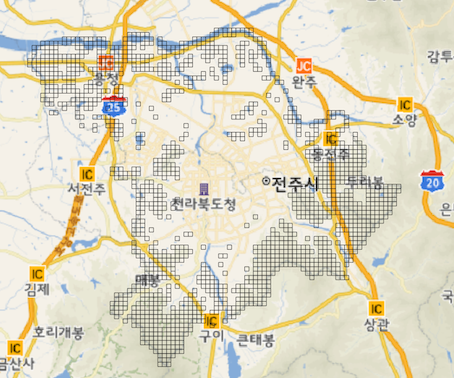

In [9]:
Image("/Users/gimdong-wan/Desktop/DataCampus/img/feat_N_grid/전체.png")

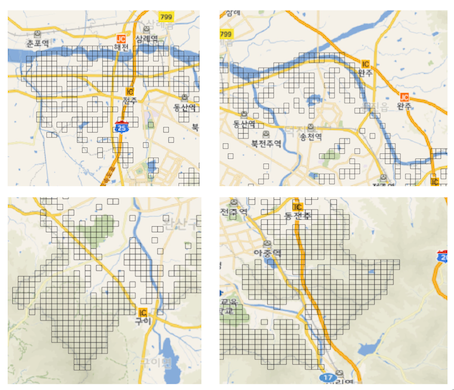

In [10]:
Image("/Users/gimdong-wan/Desktop/DataCampus/img/feat_N_grid/확대.png")

#### 해당 격자들은 대부분 산지나, 강, 도로 등 시설물이 없는 곳들을 나타낸다.  
#### 따라서 본 연구는 범죄에 영향을 미치는 요인을 파악하기 위함이므로 제거해도 좋을 것 이라 판단된다.

In [11]:
new_grid = feat_Y

In [12]:
new_grid = new_grid[new_grid['GRADE_전체']>0]

In [13]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_전체', '행정동면적',
       '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [14]:
new_grid.to_csv('/Users/gimdong-wan/Desktop/new_grid.csv',encoding='cp949')

#### 컬럼 정렬

In [15]:
new_grid = new_grid[['ID', '총인구', '유소년인구', '고령인구', '성폭력취약인구','건축물(30_34)', '건축물(35)', '건축물(30_)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', '행정동면적', 'GRADE_전체']]

In [16]:
new_grid.describe()

,총인구,유소년인구,고령인구,성폭력취약인구,건축물(30_34),건축물(35),건축물(30_),개별주택가격,공시지가,가로등,공영주차장,공중화장실,교육시설,대규모점포,대부업현황,룸살롱,버스정류장,보안등,상가,숙박업소,술집,어린이보호,어린이집,오락시설,원룸_오피스텔,음식점,자율방범대,파출소,cctv,신호등,횡단보도,행정동면적,GRADE_전체
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1.015000e+03,1.015000e+03,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,589.941872,64.836453,102.663054,48.243350,4.691626,20.240394,24.932020,1.470052e+08,5.023989e+05,12.041379,0.072906,0.268966,3.553695,0.037438,0.083744,0.270936,0.489655,8.009852,31.751724,0.400985,1.374384,0.195074,0.553695,0.803941,8.346798,11.298522,0.044335,0.018719,1.164532,3.065025,5.964532,8.396522,2.783251
std,692.165469,99.970661,124.843424,62.055607,12.274253,37.887971,42.724824,1.351262e+08,4.228989e+05,12.836180,0.295604,0.708898,7.216491,0.214323,0.343841,1.998642,0.810217,12.960032,43.320869,1.799572,3.498624,0.532360,1.243057,1.953600,18.136561,17.610081,0.205940,0.135598,1.342494,4.248878,6.707375,7.901685,1.841960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760000,1.000000
25%,41.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,5.736337e+07,2.060370e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.710000,1.000000
50%,342.000000,22.000000,59.000000,23.000000,0.000000,2.000000,3.000000,1.098500e+08,4.509660e+05,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,1.000000,1.000000,4.000000,6.270000,2.000000
75%,866.000000,85.500000,160.000000,74.000000,5.000000,20.000000,31.500000,2.073222e+08,6.641705e+05,19.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,11.000000,47.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.000000,15.000000,0.000000,0.000000,2.000000,5.000000,9.000000,15.230000,4.000000
max,3685.000000,631.000000,1081.000000,357.000000,177.000000,252.000000,259.000000,8.960000e+08,3.253211e+06,82.000000,3.000000,7.000000,81.000000,2.000000,4.000000,33.000000,5.000000,79.000000,541.000000,21.000000,32.000000,5.000000,11.000000,23.000000,206.000000,161.000000,1.000000,1.000000,7.000000,26.000000,56.000000,26.600000,10.000000


#### 전체적으로 2~3사분위수에도 0이 많은 편향된 데이터임을 알 수 있음. 이후 스케일링이 필요하며 이상치 탐색이 필요함. 

#### 타겟변수가 서열형이므로, Spearman 상관계수 이용

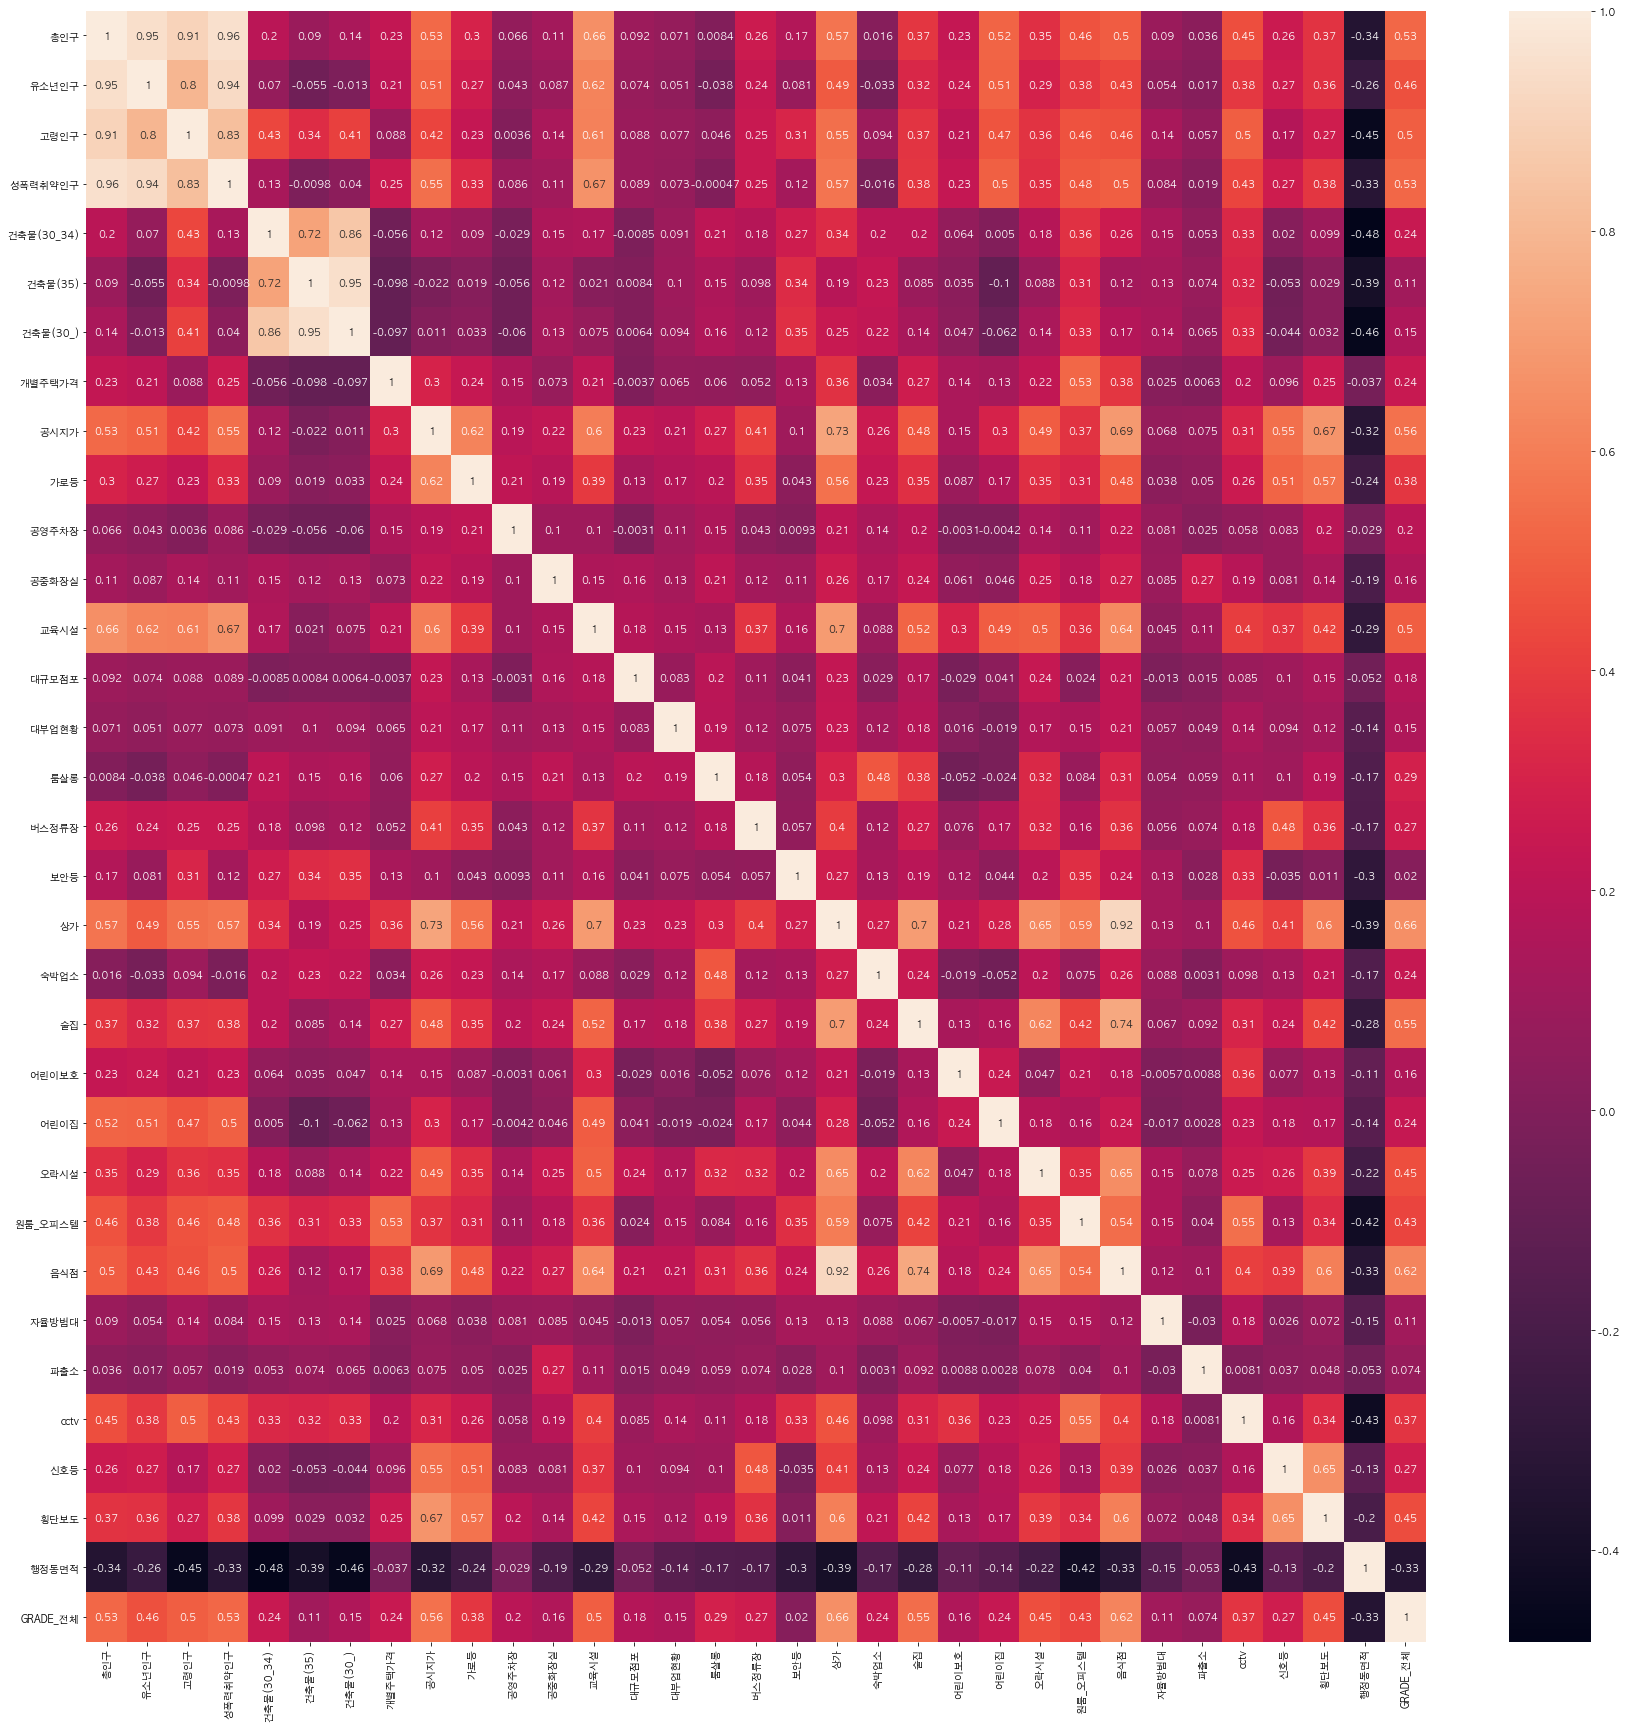

In [17]:
plt.figure(figsize=(30, 30))
sns.heatmap(new_grid.corr(method = 'spearman'), annot=True)
plt.show()

### 전체 변수 간 상관관계 
 - 인구 사회학적 변수는 변수간 상관관계가 크며, 이는 다중공선성 제거를 위해 변수를 선택할 필요가 있다. 또한, 대부분 범죄 등급과도 큰 상관관계를 보이고 있다. 

#### 종속변수 (3대범죄)를 기반으로 한 상관계수 확인
 
- `인구` : 총인구 (0.69),성폭력취약인구(0.72), 유소년인구(0.69), 고령인구(0.68)
- `토지` : 30년 이상35년 미만 건축물(0.4), 35년 이상건축물(0.28), 30년 이상 건축물 (0.33),개별주택가격 (0.38), 공시지가(0.68)
- `시설물` : 가로등(0.54), 공영주차장(0.22), 공중화장실(0.28), 교육시설(0.64), 대규모점포(0.18), 대부업체현황(0.22), 룸살롱(0.26), 버스정류장(0.4), 보안등(0.26), 상가(0.76), 숙박업소(0.24), 술집(0.57), 어린이보호구역(0.23), 어린이집(0.39), 오락시설(0.52), 원룸_오피스텔(0.61), 음식점(0.71), 자율방범대(0.17), 파출소(0.12), cctv(0.56), 신호등(0.47), 횡단보도(0.65)

In [18]:
new_grid.shape

(1015, 35)

In [19]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '성폭력취약인구', '건축물(30_34)', '건축물(35)',
       '건축물(30_)', '개별주택가격', '공시지가', '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설',
       '대규모점포', '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호',
       '어린이집', '오락시설', '원룸_오피스텔', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '행정동면적', 'GRADE_전체'],
      dtype='object')

In [20]:
def hist(x) : 
    plt.hist(new_grid[x])
    plt.xlabel(x)

In [22]:
def scatter(x) : 
    plt.plot(x,'GRADE_전체', linestyle='none', marker='o', markersize=3, color='blue', data = new_grid)
    plt.xlabel(x)


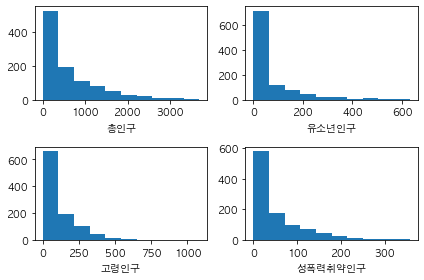

In [23]:
plt.subplot(221)
hist('총인구')

plt.subplot(222)
hist('유소년인구')

plt.subplot(223)
hist('고령인구')

plt.subplot(224)
hist('성폭력취약인구')

plt.tight_layout()
plt.show()

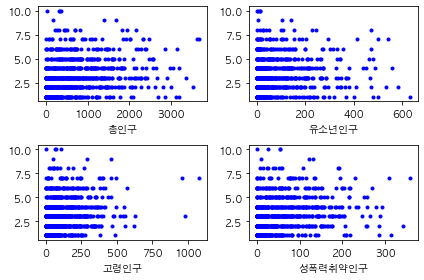

In [24]:
plt.subplot(221)
scatter('총인구')

plt.subplot(222)
scatter('유소년인구')

plt.subplot(223)
scatter('고령인구')

plt.subplot(224)
scatter('성폭력취약인구')

plt.tight_layout()
plt.show()

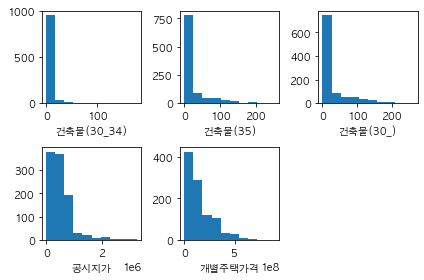

In [25]:
plt.subplot(231)
hist('건축물(30_34)')

plt.subplot(232)
hist('건축물(35)')

plt.subplot(233)
hist('건축물(30_)')

plt.subplot(234)
hist('공시지가')

plt.subplot(235)
hist('개별주택가격')

plt.tight_layout()
plt.show()

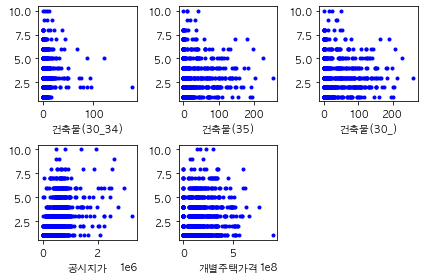

In [26]:
plt.subplot(231)
scatter('건축물(30_34)')

plt.subplot(232)
scatter('건축물(35)')

plt.subplot(233)
scatter('건축물(30_)')

plt.subplot(234)
scatter('공시지가')

plt.subplot(235)
scatter('개별주택가격')

plt.tight_layout()
plt.show()

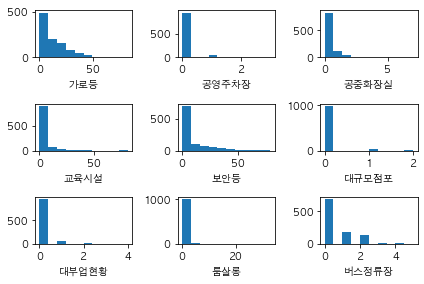

In [27]:
plt.subplot(331)
hist('가로등')

plt.subplot(332)
hist('공영주차장')

plt.subplot(333)
hist('공중화장실')

plt.subplot(334)
hist('교육시설')

plt.subplot(335)
hist('보안등')

plt.subplot(336)
hist('대규모점포')

plt.subplot(337)
hist('대부업현황')

plt.subplot(338)
hist('룸살롱')

plt.subplot(339)
hist('버스정류장')

plt.tight_layout()
plt.show()

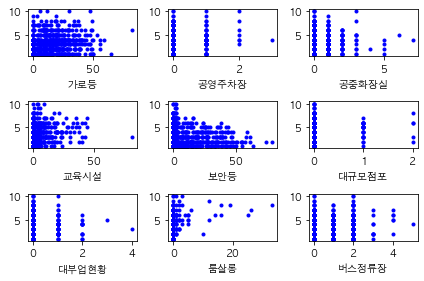

In [28]:
plt.subplot(331)
scatter('가로등')

plt.subplot(332)
scatter('공영주차장')

plt.subplot(333)
scatter('공중화장실')

plt.subplot(334)
scatter('교육시설')

plt.subplot(335)
scatter('보안등')

plt.subplot(336)
scatter('대규모점포')

plt.subplot(337)
scatter('대부업현황')

plt.subplot(338)
scatter('룸살롱')

plt.subplot(339)
scatter('버스정류장')

plt.tight_layout()
plt.show()

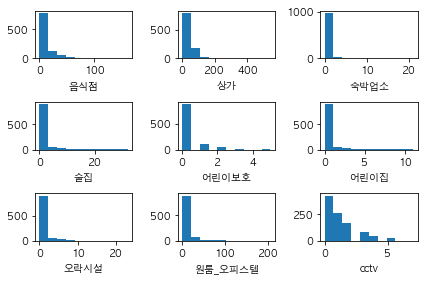

In [29]:
plt.subplot(331)
hist('음식점')

plt.subplot(332)
hist('상가')

plt.subplot(333)
hist('숙박업소')

plt.subplot(334)
hist('술집')

plt.subplot(335)
hist('어린이보호')

plt.subplot(336)
hist('어린이집')

plt.subplot(337)
hist('오락시설')

plt.subplot(338)
hist('원룸_오피스텔')

plt.subplot(339)
hist('cctv')

plt.tight_layout()
plt.show()

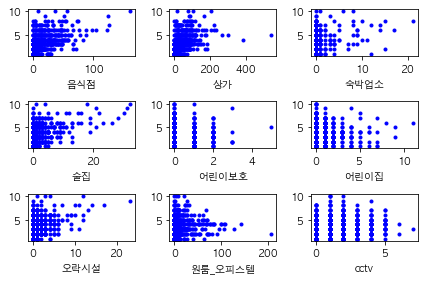

In [30]:
plt.subplot(331)
scatter('음식점')

plt.subplot(332)
scatter('상가')

plt.subplot(333)
scatter('숙박업소')

plt.subplot(334)
scatter('술집')

plt.subplot(335)
scatter('어린이보호')

plt.subplot(336)
scatter('어린이집')

plt.subplot(337)
scatter('오락시설')

plt.subplot(338)
scatter('원룸_오피스텔')

plt.subplot(339)
scatter('cctv')

plt.tight_layout()
plt.show()

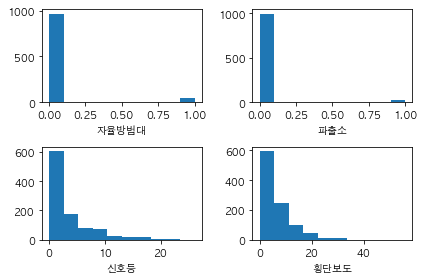

In [31]:
plt.subplot(221)
hist('자율방범대')

plt.subplot(222)
hist('파출소')

plt.subplot(223)
hist('신호등')

plt.subplot(224)
hist('횡단보도')

plt.tight_layout()
plt.show()

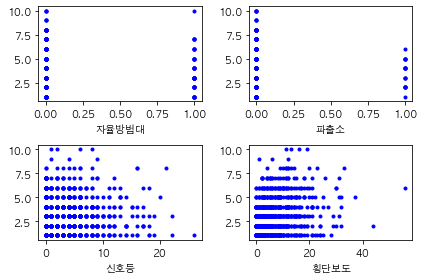

In [32]:
plt.subplot(221)
scatter('자율방범대')

plt.subplot(222)
scatter('파출소')

plt.subplot(223)
scatter('신호등')

plt.subplot(224)
scatter('횡단보도')

plt.tight_layout()
plt.show()

In [21]:
new_grid = new_grid[new_grid['개별주택가격']<4000000000]

#### 행정동면적, ID, 행정동 코드는 분석에서 제외
#### 최대값이 50미만인 변수는 MinMaxScale
#### 최대값이 50이상인 변수는 StandardScale

In [22]:
standard_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
standard_feats.remove('GRADE_전체')
standard_feats.remove('공영주차장')
standard_feats.remove('공중화장실')
standard_feats.remove('대규모점포')
standard_feats.remove('대부업현황')
standard_feats.remove('룸살롱')
standard_feats.remove('버스정류장')
standard_feats.remove('숙박업소')
standard_feats.remove('술집')
standard_feats.remove('어린이집')
standard_feats.remove('오락시설')
standard_feats.remove('cctv')
standard_feats.remove('자율방범대')
standard_feats.remove('파출소')


min_max_feats = list(new_grid.loc[:,['공영주차장','공중화장실','대규모점포','대부업현황','룸살롱','버스정류장','숙박업소','술집','어린이집','오락시설','cctv']].columns)
print("Number of Minmax features :", len(min_max_feats))
print("Number of Standard features: ", len(standard_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Minmax features : 11
Number of Standard features:  19
Number of Categorical features:  2


In [23]:
scaler = StandardScaler()
new_grid[standard_feats] = scaler.fit_transform(new_grid[standard_feats])

In [24]:
scaler = MinMaxScaler()
new_grid[min_max_feats] = scaler.fit_transform(new_grid[min_max_feats])

### 변수 선택을 위한 분산분석 실시

In [25]:
new_grid.loc[(new_grid['GRADE_전체']==0),'범죄빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_전체']>0)&(new_grid['GRADE_전체']<4),'범죄빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_전체']>=4)&(new_grid['GRADE_전체']<8),'범죄빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_전체']>=8)&(new_grid['GRADE_전체']<11),'범죄빈도_4'] = 3

In [26]:
group_1 = new_grid[new_grid['범죄빈도_4'] == 0]
group_2 = new_grid[new_grid['범죄빈도_4'] == 1]
group_3 = new_grid[new_grid['범죄빈도_4'] == 2]
group_4 = new_grid[new_grid['범죄빈도_4'] == 3]

In [27]:
def anova(x):
    F_statistic, pVal = stats.f_oneway(group_1[x], group_2[x], group_3[x], group_4[x])

    print(x,' 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
    if pVal < 0.05:
        print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [28]:
anova('총인구')
anova('유소년인구')
anova('고령인구')
anova('성폭력취약인구')
anova('건축물(30_34)')
anova('건축물(35)')
anova('건축물(30_)')
anova('개별주택가격')
anova('공시지가')
anova('가로등')
anova('보안등')
anova('공중화장실')
anova('버스정류장')
anova('공영주차장')
anova('교육시설')
anova('대규모점포')
anova('대부업현황')
anova('룸살롱')
anova('버스정류장')
anova('보안등')
anova('상가')
anova('숙박업소')
anova('술집')
anova('어린이보호')
anova('어린이집')
anova('오락시설')
anova('원룸_오피스텔')
anova('음식점')
anova('자율방범대')
anova('파출소')
anova('cctv')
anova('신호등')
anova('횡단보도')

총인구  데이터의 일원분산분석 결과 : F=nan, p=nan
유소년인구  데이터의 일원분산분석 결과 : F=nan, p=nan
고령인구  데이터의 일원분산분석 결과 : F=nan, p=nan
성폭력취약인구  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(30_34)  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(35)  데이터의 일원분산분석 결과 : F=nan, p=nan
건축물(30_)  데이터의 일원분산분석 결과 : F=nan, p=nan
개별주택가격  데이터의 일원분산분석 결과 : F=nan, p=nan
공시지가  데이터의 일원분산분석 결과 : F=nan, p=nan
가로등  데이터의 일원분산분석 결과 : F=nan, p=nan
보안등  데이터의 일원분산분석 결과 : F=nan, p=nan
공중화장실  데이터의 일원분산분석 결과 : F=nan, p=nan
버스정류장  데이터의 일원분산분석 결과 : F=nan, p=nan
공영주차장  데이터의 일원분산분석 결과 : F=nan, p=nan
교육시설  데이터의 일원분산분석 결과 : F=nan, p=nan
대규모점포  데이터의 일원분산분석 결과 : F=nan, p=nan
대부업현황  데이터의 일원분산분석 결과 : F=nan, p=nan
룸살롱  데이터의 일원분산분석 결과 : F=nan, p=nan
버스정류장  데이터의 일원분산분석 결과 : F=nan, p=nan
보안등  데이터의 일원분산분석 결과 : F=nan, p=nan
상가  데이터의 일원분산분석 결과 : F=nan, p=nan
숙박업소  데이터의 일원분산분석 결과 : F=nan, p=nan
술집  데이터의 일원분산분석 결과 : F=nan, p=nan
어린이보호  데이터의 일원분산분석 결과 : F=nan, p=nan
어린이집  데이터의 일원분산분석 결과 : F=nan, p=nan
오락시설  데이터의 일원분산분석 결과 : F=nan, p=nan
원룸_오피스텔  데이터의 일원분산분석 결과 : F=nan, p=nan
음식점  데이터

In [29]:
def compare(x,y):
    comp = MultiComparison(new_grid[x], new_grid[y])
    result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
    return result[0]

In [30]:
compare('총인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-10.0507,0.0,0.0,True
1.0,3.0,-2.1555,0.0314,0.0943,False
2.0,3.0,0.8744,0.3826,1.0,False


In [31]:
compare('유소년인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-7.3291,0.0,0.0,True
1.0,3.0,-1.9892,0.047,0.1411,False
2.0,3.0,0.296,0.7675,1.0,False


In [32]:
compare('고령인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.4082,0.0,0.0,True
1.0,3.0,-1.2166,0.2242,0.6725,False
2.0,3.0,1.2046,0.2293,0.6879,False


In [33]:
compare('성폭력취약인구','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-10.3203,0.0,0.0,True
1.0,3.0,-2.1623,0.0309,0.0928,False
2.0,3.0,0.946,0.3449,1.0,False


In [34]:
compare('건축물(30_34)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-1.6813,0.093,0.2791,False
1.0,3.0,-1.14,0.2547,0.764,False
2.0,3.0,-0.621,0.535,1.0,False


In [35]:
compare('건축물(35)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.1229,0.034,0.102,False
1.0,3.0,1.0388,0.2992,0.8977,False
2.0,3.0,1.5139,0.1311,0.3934,False


In [36]:
compare('건축물(30_)','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.3656,0.0182,0.0546,False
1.0,3.0,0.5799,0.5621,1.0,False
2.0,3.0,1.175,0.2409,0.7227,False


In [37]:
compare('개별주택가격','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.6245,0.0,0.0,True
1.0,3.0,-1.9833,0.0477,0.1431,False
2.0,3.0,-0.2097,0.834,1.0,False


In [38]:
compare('공시지가','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-11.2127,0.0,0.0,True
1.0,3.0,-7.2646,0.0,0.0,True
2.0,3.0,-3.1847,0.0016,0.0048,True


In [39]:
compare('공영주차장','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.9717,0.0,0.0,True
1.0,3.0,-7.7485,0.0,0.0,True
2.0,3.0,-2.5983,0.0098,0.0295,True


In [40]:
compare('공중화장실','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.1597,0.0,0.0001,True
1.0,3.0,-1.8717,0.0616,0.1849,False
2.0,3.0,-0.2917,0.7707,1.0,False


In [41]:
compare('교육시설','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-9.3375,0.0,0.0,True
1.0,3.0,-1.4611,0.1444,0.4333,False
2.0,3.0,1.2047,0.2293,0.6879,False


In [42]:
compare('대규모점포','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.738,0.0,0.0,True
1.0,3.0,-2.3247,0.0204,0.0611,False
2.0,3.0,-0.2696,0.7876,1.0,False


In [43]:
compare('대부업현황','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.4304,0.0,0.0,True
1.0,3.0,-0.783,0.4339,1.0,False
2.0,3.0,0.5132,0.6082,1.0,False


In [44]:
compare('룸살롱','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.1672,0.0,0.0,True
1.0,3.0,-14.2067,0.0,0.0,True
2.0,3.0,-5.2944,0.0,0.0,True


In [45]:
compare('버스정류장','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-6.6091,0.0,0.0,True
1.0,3.0,-4.1271,0.0,0.0001,True
2.0,3.0,-1.346,0.1793,0.538,False


In [46]:
compare('보안등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,1.2562,0.2093,0.628,False
1.0,3.0,2.5137,0.0122,0.0365,True
2.0,3.0,2.3776,0.0181,0.0542,False


In [47]:
compare('상가','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-15.4008,0.0,0.0,True
1.0,3.0,-8.9818,0.0,0.0,True
2.0,3.0,-1.264,0.2072,0.6216,False


In [48]:
compare('숙박업소','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.3601,0.0,0.0,True
1.0,3.0,-11.9141,0.0,0.0,True
2.0,3.0,-5.0409,0.0,0.0,True


In [49]:
compare('술집','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-13.021,0.0,0.0,True
1.0,3.0,-22.1645,0.0,0.0,True
2.0,3.0,-7.588,0.0,0.0,True


In [50]:
compare('어린이보호','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-4.0735,0.0,0.0001,True
1.0,3.0,-1.0246,0.3059,0.9176,False
2.0,3.0,0.2438,0.8075,1.0,False


In [51]:
compare('어린이집','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-5.2876,0.0,0.0,True
1.0,3.0,-0.6313,0.528,1.0,False
2.0,3.0,0.8002,0.4242,1.0,False


In [52]:
compare('오락시설','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-10.2555,0.0,0.0,True
1.0,3.0,-15.5633,0.0,0.0,True
2.0,3.0,-6.7487,0.0,0.0,True


In [53]:
compare('원룸_오피스텔','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-7.0674,0.0,0.0,True
1.0,3.0,-0.9606,0.3371,1.0,False
2.0,3.0,1.0236,0.3068,0.9205,False


In [54]:
compare('음식점','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-16.0005,0.0,0.0,True
1.0,3.0,-14.7453,0.0,0.0,True
2.0,3.0,-4.4957,0.0,0.0,True


In [55]:
compare('자율방범대','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.2426,0.0251,0.0754,False
1.0,3.0,-0.4092,0.6825,1.0,False
2.0,3.0,0.249,0.8036,1.0,False


In [56]:
compare('파출소','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-2.38,0.0175,0.0525,False
1.0,3.0,0.4918,0.623,1.0,False
2.0,3.0,0.833,0.4055,1.0,False


In [57]:
compare('cctv','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.1587,0.0,0.0,True
1.0,3.0,-1.2647,0.2064,0.6191,False
2.0,3.0,1.1406,0.255,0.7649,False


In [58]:
compare('신호등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-3.6717,0.0003,0.0008,True
1.0,3.0,-3.5301,0.0004,0.0013,True
2.0,3.0,-2.4825,0.0136,0.0408,True


In [59]:
compare('횡단보도','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.997,0.0,0.0,True
1.0,3.0,-6.1162,0.0,0.0,True
2.0,3.0,-2.5384,0.0116,0.0349,True


In [60]:
compare('가로등','범죄빈도_4')

group1,group2,stat,pval,pval_corr,reject
1.0,2.0,-8.8725,0.0,0.0,True
1.0,3.0,-3.6185,0.0003,0.001,True
2.0,3.0,-0.734,0.4635,1.0,False


#### 선택한 변수 :  
'공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔','개별주택가격','건축물(35)',cctv
                                   

In [61]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)']].columns)

feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

### 다중공선성 확인

In [62]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,2.272681,공시지가
1,1.272602,숙박업소
2,3.586687,술집
3,2.337532,오락시설
4,3.566379,음식점
5,1.184324,공영주차장
6,1.854017,가로등
7,1.813543,횡단보도
8,1.616045,신호등
9,1.120764,총인구


### 다중공선성 확인 결과 분석에 영향을 미칠만한 공선성은 없는 것으로 보임

In [63]:
len(new_grid)

1015

In [64]:
407, 1630

(407, 1630)

#### 로지스틱, 데이터 100% 

In [65]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.774384236453202


array([[653,  61,   0],
       [153, 129,   0],
       [  5,  10,   4]])

### 로지스틱 다중분류 데이터 70%

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature,target, test_size=0.3, stratify=target, random_state=123456)

In [67]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=X_train, y=y_train) # 학습수행 
y_pred = model.predict(X = X_test)
acc=accuracy_score(y_test,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred) 
con_mat 

accuracy = 0.760655737704918


array([[193,  20,   1],
       [ 48,  37,   0],
       [  1,   3,   2]])

### 렌포 데이터 70%

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123)

In [69]:
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=123)

In [70]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.746
Mean accuracy score: 0.78


array([[197,  17,   0],
       [ 46,  39,   0],
       [  2,   2,   2]])

In [71]:
np.array(rf.feature_importances_)

array([0.15056243, 0.02402607, 0.09400521, 0.04180727, 0.12795812,
       0.00680391, 0.08296813, 0.07575397, 0.06146281, 0.12832155,
       0.0658518 , 0.08055552, 0.05992322])

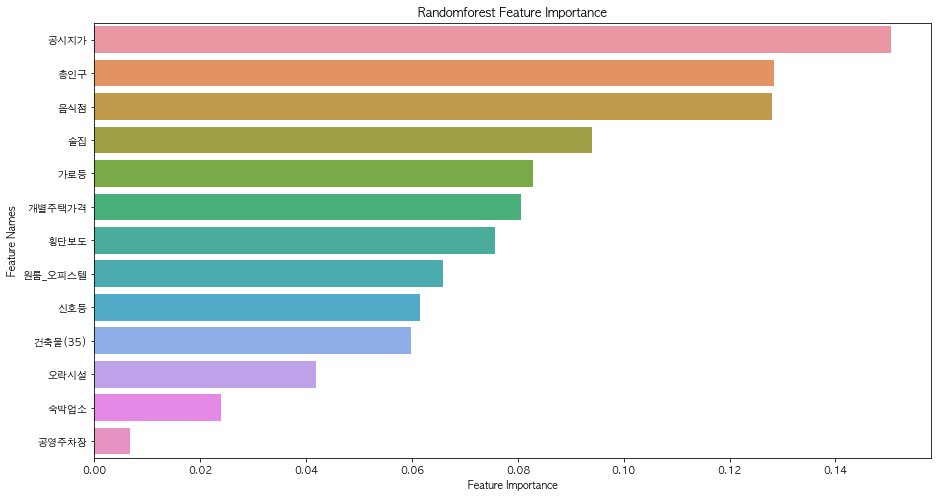

In [72]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(15,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')



plot_feature_importance(rf.feature_importances_,feature_list,'Randomforest')

In [73]:
feature_list

['공시지가',
 '숙박업소',
 '술집',
 '오락시설',
 '음식점',
 '공영주차장',
 '가로등',
 '횡단보도',
 '신호등',
 '총인구',
 '원룸_오피스텔',
 '개별주택가격',
 '건축물(35)']

In [74]:
rf.feature_importances_

array([0.15056243, 0.02402607, 0.09400521, 0.04180727, 0.12795812,
       0.00680391, 0.08296813, 0.07575397, 0.06146281, 0.12832155,
       0.0658518 , 0.08055552, 0.05992322])

### GBM

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer



cancer = load_breast_cancer()

In [76]:
gbc = GradientBoostingClassifier(random_state=0) # 기본값: max_depth=3, learning_rate=0.1

gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [77]:
predicted = gbc.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.746
Mean accuracy score: 0.734


array([[189,  25,   0],
       [ 47,  33,   5],
       [  2,   2,   2]])

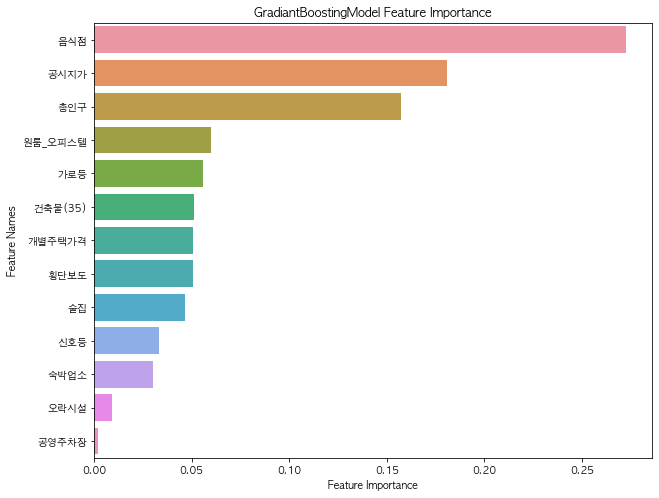

In [78]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')



plot_feature_importance(gbc.feature_importances_,feature_list,'GradiantBoostingModel')

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
KNN = KNeighborsClassifier(n_neighbors = 4)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [81]:
predicted = KNN.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
con_mat = confusion_matrix(y_true=y_test, y_pred=predicted) 
con_mat 

Out-of-bag score estimate: 0.746
Mean accuracy score: 0.728


array([[196,  18,   0],
       [ 59,  26,   0],
       [  2,   4,   0]])

### k-fold 교차분석

#### 로지스틱

In [82]:
feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','룸살롱','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)

feature = new_grid[feature_list]
target = new_grid[['범죄빈도_4']]

In [84]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
    con_mat = confusion_matrix(y_true=df_test['범죄빈도_4'], y_pred=y_pred2) 
    print(con_mat)
print(scores)
scores.mean()

학습 Accuracy = 0.74630542, 검증 Accuracy = 0.88177340
[[172  10   0]
 [ 10   7   0]
 [  3   1   0]]
학습 Accuracy = 0.76847291, 검증 Accuracy = 0.81773399
[[126  21   0]
 [ 15  39   0]
 [  0   1   1]]
학습 Accuracy = 0.78940887, 검증 Accuracy = 0.69458128
[[109  22   0]
 [ 38  31   1]
 [  0   1   1]]
학습 Accuracy = 0.80541872, 검증 Accuracy = 0.67487685
[[114   9   0]
 [ 53  23   0]
 [  2   2   0]]
학습 Accuracy = 0.77832512, 검증 Accuracy = 0.73399015
[[125   6   0]
 [ 41  24   0]
 [  2   5   0]]
[0.8817734  0.81773399 0.69458128 0.67487685 0.73399015]


0.7605911330049261

#### 랜포

In [89]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model =  RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0,max_depth=5)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
    con_mat = confusion_matrix(y_true=df_test['범죄빈도_4'], y_pred=y_pred2) 
    print(con_mat)
print(scores)
scores.mean()

학습 Accuracy = 0.84605911, 검증 Accuracy = 0.75862069
[[123  20   0]
 [ 25  31   0]
 [  0   4   0]]
학습 Accuracy = 0.83743842, 검증 Accuracy = 0.81280788
[[136  17   0]
 [ 16  29   0]
 [  3   2   0]]
학습 Accuracy = 0.84359606, 검증 Accuracy = 0.77832512
[[134  13   0]
 [ 31  24   0]
 [  0   1   0]]
학습 Accuracy = 0.84729064, 검증 Accuracy = 0.76847291
[[126  10   0]
 [ 31  30   0]
 [  3   3   0]]
학습 Accuracy = 0.84482759, 검증 Accuracy = 0.73399015
[[125  10   0]
 [ 41  24   0]
 [  0   3   0]]
[0.75862069 0.81280788 0.77832512 0.76847291 0.73399015]


0.7704433497536946

#### GBM

In [101]:
new_grid[new_grid['범죄빈도_4']>2]

,ID,총인구,유소년인구,고령인구,성폭력취약인구,건축물(30_34),건축물(35),건축물(30_),개별주택가격,공시지가,행정동코드,가로등,공영주차장,공중화장실,교육시설,대규모점포,대부업현황,룸살롱,버스정류장,보안등,상가,숙박업소,술집,어린이보호,어린이집,오락시설,원룸_오피스텔,음식점,자율방범대,파출소,cctv,신호등,횡단보도,행정동면적,GRADE_전체,범죄빈도_4
458,다마60ab60ab,2.270891,4.044815,-0.173607,2.269352,-0.382422,-0.534480,-0.583836,-1.088446,4.780325,혁신동,1.945355,0.000000,0.000000,1.864193,1.0,0.00,0.000000,0.0,-0.618347,0.513823,0.000000,0.00000,-0.366613,0.000000,0.000000,-0.405282,0.494363,0,0,0.285714,0.691105,0.601943,-0.641511,8.0,3.0
512,다마60ba60ab,0.140293,0.882329,-0.478139,0.060567,-0.382422,-0.534480,-0.583836,-1.088446,2.277795,혁신동,1.711525,0.000000,0.000000,-0.492684,0.0,0.00,0.000000,0.4,-0.618347,-0.733304,0.000000,0.00000,-0.366613,0.000000,0.000000,-0.460446,-0.641910,0,0,0.428571,3.045828,0.751106,-0.641511,8.0,3.0
731,다마61ab63bb,1.779437,1.642927,1.349049,0.947305,-0.382422,-0.481667,-0.537002,-0.502779,0.000658,여의동,0.230604,0.000000,0.000000,-0.076764,0.0,0.00,0.000000,0.4,-0.618347,-0.525450,0.000000,0.06250,-0.366613,0.000000,0.000000,-0.460446,-0.414656,0,0,0.000000,0.691105,0.452780,0.924749,8.0,3.0
943,다마62aa61ab,-0.231189,0.361920,-0.622390,-0.358619,-0.382422,-0.534480,-0.583836,-1.088446,0.955931,여의동,-0.938544,0.000000,0.000000,-0.354044,0.0,0.00,0.000000,0.0,-0.618347,-0.548545,0.000000,0.00000,-0.366613,0.000000,0.000000,-0.460446,-0.471469,0,0,0.000000,4.223189,1.049432,0.924749,8.0,3.0
1626,다마64ba57bb,-0.822379,-0.648875,-0.822740,-0.777805,-0.382422,-0.534480,-0.583836,1.147603,3.424560,효자5동,2.724787,0.666667,0.000000,-0.076764,0.0,0.25,0.090909,0.0,-0.618347,4.001159,0.380952,1.00000,-0.366613,0.000000,0.521739,-0.460446,8.505088,0,0,0.285714,1.162050,1.944411,-0.269255,10.0,3.0
1692,다마64bb57bb,1.955783,1.783037,0.427441,2.301597,-0.382422,-0.534480,-0.583836,3.368843,3.244795,효자5동,2.880673,0.666667,0.000000,-0.492684,0.0,0.00,0.030303,0.2,-0.618347,0.883342,0.190476,0.37500,-0.366613,0.090909,0.217391,-0.405282,2.141959,0,0,0.000000,0.220161,0.900269,-0.269255,8.0,3.0
2042,다마66aa60bb,-0.382961,-0.518772,-0.253747,-0.358619,0.351182,0.548191,0.587020,-0.051081,2.095247,덕진동,1.399752,0.333333,0.428571,0.061876,0.0,0.00,0.030303,0.4,-0.463951,1.645475,0.285714,0.56250,1.512740,0.000000,0.173913,-0.294953,2.539654,1,0,0.142857,0.691105,1.496922,-0.457916,10.0,3.0
2109,다마66ab60bb,-0.596888,-0.578819,-0.422041,-0.600457,1.166297,-0.059161,0.282598,-0.408952,4.972206,덕진동,0.542377,0.000000,0.000000,0.061876,0.0,0.00,0.060606,0.0,-0.463951,3.054266,0.000000,0.96875,-0.366613,0.000000,1.000000,-0.460446,6.402982,0,0,0.142857,0.220161,0.900269,-0.457916,9.0,3.0
2174,다마66ba60ba,-0.320807,-0.498757,0.050784,0.108934,0.677228,-0.244008,-0.021825,0.620719,0.700603,금암1동,-0.003225,0.000000,0.000000,0.755075,0.0,0.00,0.000000,0.0,-0.541149,1.045006,0.047619,0.12500,-0.366613,0.000000,0.130435,-0.074295,1.460195,0,0,0.142857,-0.486256,1.049432,-0.904876,10.0,3.0
2236,다마66bb59bb,-0.411870,-0.368654,-0.373957,-0.552089,0.432694,0.416158,0.493352,-0.302361,0.718138,금암1동,-0.392941,0.000000,0.142857,-0.492684,0.0,0.00,0.090909,0.4,-0.463951,0.952627,0.476190,0.15625,-0.366613,0.000000,0.043478,-0.405282,1.857890,0,0,0.285714,-0.015311,-0.293036,-0.904876,8.0,3.0


In [100]:
grid_250[grid_250['GRADE_전체']>7]

,INDEX,ID,총인구,고등여성인구,20대여성인구,유소년인구,고령인구,건축물(30_34),건축물(35),개별주택가격,공시지가,행정동코드,가로등,공영주차장,공중화장실,교육시설,대규모점포,대부업현황,룸살롱,버스정류장,보안등,상가,숙박업소,술집,어린이보호,어린이집,오락시설,원룸_오피스텔,음식점,자율방범대,파출소,cctv,신호등,횡단보도,GRADE_전체,행정동면적
458,458,다마60ab60ab,2161.0,68.0,121.0,469.0,81.0,0.0,0.0,0,2522997,혁신동,37,0,0,17,2,0,0,0,0,54,0,0,0,0,0,1,20,0,0,2,6,10,9.0,3.33
512,512,다마60ba60ab,687.0,17.0,35.0,153.0,43.0,0.0,0.0,0,1465201,혁신동,34,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,16,11,9.0,3.33
731,731,다마61ab63bb,1821.0,14.0,93.0,229.0,271.0,0.0,2.0,79100000,502677,여의동,15,0,0,3,0,0,0,2,0,9,0,2,0,0,0,0,4,0,0,0,6,9,9.0,15.70
804,804,다마61ba63bb,1179.0,13.0,71.0,121.0,238.0,4.0,29.0,153943478,411707,여의동,38,0,1,1,0,0,0,0,1,12,0,0,0,0,1,9,2,1,0,2,0,4,8.0,15.70
943,943,다마62aa61ab,430.0,0.0,26.0,101.0,25.0,0.0,0.0,0,906462,여의동,0,0,0,1,0,0,0,0,0,8,0,0,0,0,0,0,3,0,0,0,21,13,9.0,15.70
1626,1626,다마64ba57bb,21.0,0.0,0.0,0.0,0.0,0.0,0.0,302000000,1949928,효자5동,47,2,0,3,0,1,3,0,0,205,8,32,0,0,12,0,161,0,0,2,8,19,11.0,6.27
1692,1692,다마64bb57bb,1943.0,30.0,161.0,243.0,156.0,0.0,0.0,602000000,1873943,효자5동,49,2,0,0,0,0,1,1,0,70,4,12,0,1,5,1,49,0,0,0,4,12,9.0,6.27
1782,1782,다마65aa63ba,926.0,17.0,60.0,66.0,186.0,2.0,1.0,146275000,689198,송천2동,14,1,0,1,0,0,0,0,0,93,0,0,1,1,0,0,6,0,0,2,8,14,8.0,12.14
1783,1783,다마65aa63bb,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,252739,송천2동,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,9,11,8.0,12.14
2042,2042,다마66aa60bb,325.0,0.0,26.0,13.0,71.0,9.0,41.0,140106250,1388040,덕진동,30,1,3,4,0,0,1,2,2,103,6,18,1,0,4,3,56,1,0,1,6,16,11.0,4.78


In [112]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model =  GradientBoostingClassifier(random_state=0)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.93349754, 검증 Accuracy = 0.88177340
학습 Accuracy = 0.95935961, 검증 Accuracy = 0.79310345
학습 Accuracy = 0.95320197, 검증 Accuracy = 0.68472906
학습 Accuracy = 0.96182266, 검증 Accuracy = 0.68472906
학습 Accuracy = 0.95197044, 검증 Accuracy = 0.69458128
[0.8817734  0.79310345 0.68472906 0.68472906 0.69458128]


0.7477832512315271

### KNN

In [113]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=False, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.loc[:,['공시지가','숙박업소','술집','오락시설','음식점','공영주차장','가로등','횡단보도','신호등','총인구','원룸_오피스텔'
                                   ,'개별주택가격','건축물(35)','cctv']].columns)
    feature = df_train[feature_list]
    target = df_train[['범죄빈도_4']]
    
    
    model = KNeighborsClassifier(n_neighbors = 4)
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(y_pred1,target)
    acc_2=accuracy_score(df_test['범죄빈도_4'],y_pred2)
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.77832512, 검증 Accuracy = 0.90147783
학습 Accuracy = 0.80911330, 검증 Accuracy = 0.75369458
학습 Accuracy = 0.80788177, 검증 Accuracy = 0.67487685
학습 Accuracy = 0.82512315, 검증 Accuracy = 0.62068966
학습 Accuracy = 0.81403941, 검증 Accuracy = 0.65517241
[0.90147783 0.75369458 0.67487685 0.62068966 0.65517241]


0.7211822660098521